# Airbnb New User Bookings
*Where will a new guest book their first travel experience?*

* [Kaggle Page](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings)

**Outline**

* [Read Data](#read)
* [Data Summary](#data check)
* [Exploratory Data Analysis](#eda)
* [Feature Creation and Preprocessing](#preprocess)
* [Model and Score](#model) 
* [Predicition](#predict)
* [Reference](#reference)

**Related Notebooks**
- Link to [Airbnb 2.26.18 - Model Development & Evaluation](Airbnb 2.26.18 - Model Development & Evaluation.ipynb)

In [88]:
#%load_ext watermark

In [87]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import model_selection
from sklearn.neural_network import MLPClassifier

SEED = 12345

In [2]:
#%watermark -a 'PredictiveII' -d -t -v -p pandas,numpy,sklearn,watermark

---

## <a id="read">Read Data</a>

In [32]:
def data_reader():
    """
    read data into notebook 
    """
        
    data_dir = os.path.join('.', 'data') #/Users/siliangchen/Airbnb

    session_path = os.path.join(data_dir, 'sessions.csv')
    train_path = os.path.join(data_dir, 'train_users_2.csv')    
    test_path = os.path.join(data_dir, 'test_users.csv')   
    age_gender_bkt_path = os.path.join(data_dir, 'age_gender_bkts.csv')   
    country_path = os.path.join(data_dir, 'countries.csv')   
    sample_submission_path = os.path.join(data_dir, 'sample_submission_NDF.csv')   

    session = pd.read_csv(session_path)
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    age_gender = pd.read_csv(age_gender_bkt_path)
    country = pd.read_csv(country_path)
    sample_submission = pd.read_csv(sample_submission_path)

    
    return session, train, test, age_gender, country, sample_submission

In [51]:
session, train, test, age_gender, country, sample_submission = data_reader()

## <a id="data check">Data Summary</a>

### Data dictionary:
** Table 1. Session: web sessions log for users (can be joined with tables for additional feature extraction)**
* **user_id**: to be joined with the column 'id' in users table
* **action**
* **action_type**
* **action_detail**
* **device_type**
* **secs_elapsed**

** Table 2. Train user: the training set of users**
* **id**: user id
* **date_account_created**: the date of account creation
* **timestamp_first_active**: timestamp of the first activity, note that it can be earlier than date_account_created or date_first_booking because a user can search before signing up.
* **date_first_booking**: date of first booking
* **gender**
* **age**
* **signup_method**
* **signup_flow**: the page a user came to signup up from
* **language**: international language preference
* **affiliate_channel**: what kind of paid marketing
* **affiliate_provider**: where the marketing is e.g. google, craigslist, other
* **first_affiliate_tracked**: whats the first marketing the user interacted with before the signing up
* **signup_app**
* **first_device_type**
* **first_browser**
* **country_destination**: this is the target variable you are to predict

** Table 3. age_gender: summary statistics of users' age group, gender, country of destination **

** Table 4. country: summary statistics of destination countries in this dataset and their locations **

** Table 5. test user: the testing set of users **

### Data clean and feature engineering:
### Session
1. missing data (34496 user_id = NaN, 0.3% of total rows, dropped and saved a session_v1)
2. added features based on time spent and actions
3. rollup data and extract features

In [34]:
#Data overview
unique_user_count = len(set(session["user_id"])) #135484 unique users in session
print(session.shape)
session.head(2)
null_userid = session[pd.isnull(session["user_id"])]
len(null_userid) #can't use these consecutive null user ids link information, drop these user IDs

#drop rows where userid is null
session_v1 = session.dropna(axis = 0, subset = ["user_id"])
print(session_v1.shape)

(10567737, 6)
(10533241, 6)


In [35]:
session_v1.tail(3)
session_v1["device_type"].value_counts()
session_v1["action_type"].value_counts()

view                3549375
data                2096655
click               1990058
-unknown-           1028251
submit               620063
message_post          86925
partner_callback      19053
booking_request       18762
modify                 1138
booking_response          4
Name: action_type, dtype: int64

In [36]:
#Feature creation
def add_features(group):
    group["obs_count"] = group.user_id.count()
    group["action_count"] = group.action.nunique()
    group["total_secs_elapsed"] = group.secs_elapsed.sum()
    group["avg time"] = group["total_secs_elapsed"]/group["obs_count"]
    group["unique_device"] = group.device_type.nunique()
    return group

session_v2 = session_v1.groupby(['user_id']).apply(add_features)

In [151]:
session_v2.head(127)

,user_id,action,action_type,action_detail,device_type,secs_elapsed,total_secs_elapsed,obs_count,action_count,avg time,unique_device
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0,3427210.0,126,16,27200.079365,2
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0,3427210.0,126,16,27200.079365,2
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0,3427210.0,126,16,27200.079365,2
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0,3427210.0,126,16,27200.079365,2
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703.0,3427210.0,126,16,27200.079365,2
6,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,115.0,3427210.0,126,16,27200.079365,2
7,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831.0,3427210.0,126,16,27200.079365,2
8,d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842.0,3427210.0,126,16,27200.079365,2
9,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,683.0,3427210.0,126,16,27200.079365,2
10,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,59274.0,3427210.0,126,16,27200.079365,2


### Train
1. max(age) = 2014 is obvriously wrong, need to check on age column and recompute
2. many columns have missing information that need to be taken care of
2. lots of gender unknown

In [37]:
#check each row has a unique user id
print(train.shape)
unique_user_count = len(set(train["id"]))
print(unique_user_count)

#check summary stats
train.head(5)
train.describe(include = "all") #many cols have missing information

(213451, 16)
213451


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,213451,213451,2.134510e+05,88908,213451,125461.000000,213451,213451.000000,213451,213451,213451,207386,213451,213451,213451,213451
unique,213451,1634,NaN,1976,4,NaN,3,NaN,25,8,18,7,4,9,52,12
top,0qknvi0db2,2014-05-13,NaN,2014-05-22,-unknown-,NaN,basic,NaN,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,1,674,NaN,248,95688,NaN,152897,NaN,206314,137727,137426,109232,182717,89600,63845,124543
mean,NaN,NaN,2.013085e+13,NaN,NaN,49.668335,NaN,3.267387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,9.253717e+09,NaN,NaN,155.666612,NaN,7.637707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,2.009032e+13,NaN,NaN,1.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,2.012123e+13,NaN,NaN,28.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,2.013091e+13,NaN,NaN,34.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,2.014031e+13,NaN,NaN,43.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
#age distribution
print(train.age.describe())
print(len(train[train["age"]>90])) #jc: 1.2% of age above 90, drop these? team decision
train[train["age"]>90]

#train['date_first_booking']

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64
2543


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
388,v2x0ms9c62,2010-04-11,20100411065602,2010-04-13,-unknown-,2014.0,basic,3,en,other,craigslist,untracked,Web,Windows Desktop,Firefox,FR
398,9ouah6tc30,2010-04-12,20100412231534,2010-04-12,FEMALE,104.0,facebook,3,en,other,craigslist,linked,Web,iPhone,Mobile Safari,FR
627,dc3udjfdij,2010-05-19,20100519012455,2010-06-16,-unknown-,105.0,basic,2,en,other,craigslist,omg,Web,Mac Desktop,Safari,FR
645,ixv5186g1h,2010-05-21,20100521070029,NaN,MALE,95.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
673,umf1wdk9uc,2010-05-25,20100525155541,NaN,FEMALE,2014.0,basic,2,en,other,craigslist,untracked,Web,Mac Desktop,Safari,NDF
777,kqf8b3ta98,2010-06-07,20100607184626,NaN,FEMALE,94.0,basic,0,en,content,google,linked,Web,Mac Desktop,Safari,NDF
1040,m82epwn7i8,2010-07-14,20100714230556,2010-07-15,MALE,2014.0,facebook,0,en,other,craigslist,untracked,Web,Mac Desktop,Chrome,US
1177,2th813zdx7,2010-07-25,20100725234419,2010-07-26,MALE,2013.0,facebook,3,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
1190,qc9se9qucz,2010-07-27,20100727002029,2010-07-27,-unknown-,105.0,basic,2,en,other,craigslist,untracked,Web,Mac Desktop,Firefox,US
1200,3amf04n3o3,2010-07-27,20100727190447,2010-07-29,FEMALE,2014.0,basic,2,en,direct,direct,untracked,Web,Windows Desktop,IE,US


In [39]:
train[train.age>1000].age.value_counts()

2014.0    710
2013.0     39
1932.0      3
1931.0      3
1949.0      3
1924.0      2
1936.0      2
1947.0      2
1929.0      2
1928.0      2
1952.0      1
1938.0      1
1933.0      1
1927.0      1
1942.0      1
1995.0      1
2008.0      1
1953.0      1
1926.0      1
1925.0      1
1935.0      1
Name: age, dtype: int64

In [40]:
train[(train.age>90) & (train.age<1000)].age.value_counts()

105.0    1131
110.0     196
95.0       49
104.0      48
102.0      34
109.0      31
100.0      26
103.0      26
96.0       25
101.0      23
107.0      23
93.0       18
99.0       17
106.0      17
98.0       15
108.0      15
92.0       14
115.0      13
91.0       12
94.0       12
97.0       10
113.0       4
111.0       2
112.0       1
150.0       1
132.0       1
Name: age, dtype: int64

In [41]:
train[(train.age<15)].age.value_counts()

5.0    45
2.0     7
4.0     3
1.0     2
Name: age, dtype: int64

In [42]:
def ageTransform(age):
    """
    Replace strange ages
    """
    current_year = 2014
    if (age>2000):
        new_age = 34 #replace it with median
    elif (age>1000):
        new_age = 2014-age+1
    elif (age>100):
        new_age = 90 
    elif (age<10):
        new_age = 34 #replace it with median
    elif (math.isnan(age)):
        new_age = 34 #replace it with median
    else:
        new_age = age                    

    return new_age   

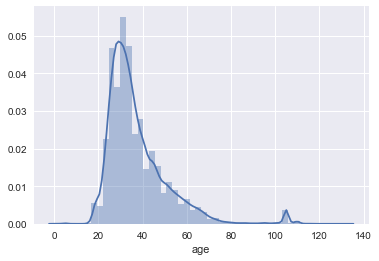

In [43]:
# Original Age Distribution
train_age = train[(train.age.notnull()) & (train.age<150)]
sn.distplot(train_age['age'])

In [44]:
train['age'] = train['age'].apply(lambda x: ageTransform(x))

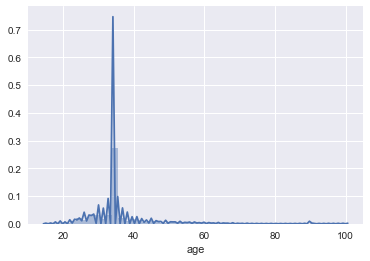

In [45]:
# New Age Distribution, replace lots of NaN's with median, which is 34.
sn.distplot(train['age'])

In [46]:
train.age.describe()

count    213451.000000
mean         35.892186
std          10.113310
min          15.000000
25%          32.000000
50%          34.000000
75%          35.000000
max         100.000000
Name: age, dtype: float64

### Age_gender

In [47]:
age_gender.shape
age_gender.head(5)
#set(age_gender["year"])

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


summary statistics of users' age group, gender, country of destination

## country

correct format for submitting your predictions

In [48]:
country.head()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06


### Test

In [54]:
session.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [58]:
test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [59]:
#merge sessions with test data
pd.merge(test, session, how='left',left_on = 'id',right_on = 'user_id')

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,first_affiliate_tracked,signup_app,first_device_type,first_browser,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,...,untracked,Moweb,iPhone,Mobile Safari,5uwns89zht,show,view,user_profile,-unknown-,79.0
1,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,...,untracked,Moweb,iPhone,Mobile Safari,5uwns89zht,search,click,view_search_results,-unknown-,17962.0
2,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,...,untracked,Moweb,iPhone,Mobile Safari,5uwns89zht,search,click,view_search_results,-unknown-,64883.0
3,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,...,untracked,Moweb,iPhone,Mobile Safari,5uwns89zht,show,view,p3,-unknown-,31180.0
4,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,...,untracked,Moweb,iPhone,Mobile Safari,5uwns89zht,authenticate,submit,login,iPhone,NaN
5,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,...,untracked,Moweb,iPhone,Mobile Safari,5uwns89zht,reviews,data,listing_reviews,-unknown-,1097.0
6,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,...,untracked,Moweb,iPhone,Mobile Safari,5uwns89zht,active,-unknown-,-unknown-,-unknown-,1046.0
7,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,...,untracked,Moweb,iPhone,Mobile Safari,5uwns89zht,search,click,view_search_results,-unknown-,2940.0
8,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,...,untracked,Moweb,iPhone,Mobile Safari,jtl0dijy2j,dashboard,view,dashboard,iPhone,747.0
9,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,...,untracked,Moweb,iPhone,Mobile Safari,jtl0dijy2j,login,view,login_page,iPhone,3228.0


In [60]:
test.head()
min(test['date_account_created'])

'2014-07-01'

---

## Data Transformation

**Train**

In [61]:
def ageTransform(age):
    """
    Replace strange ages
    """
    current_year = 2014
    if (age>2000):
        new_age = 34 #replace it with median
    elif (age>1000):
        new_age = 2014-age+1
    elif (age>100):
        new_age = 90 
    elif (age<10):
        new_age = 34 #replace it with median
    elif (math.isnan(age)):
        new_age = 34 #replace it with median
    else:
        new_age = age                    

    return new_age   

In [62]:
def train_cleaner(train):
    """
    data transformation for train dataframe
    """
    df = train.copy()
    
    # replace strange ages
    df['age'] = df['age'].apply(lambda x: ageTransform(x))
    
    # replace value with most common values, which is "untracked"
    df['first_affiliate_tracked'] = df['first_affiliate_tracked'].fillna('untracked')
    
    # change column name id into user_id in order to merge with session data
    df = df.rename(columns={'id':'user_id'})
    
    return df

In [63]:
train = train_cleaner(train)

**Session**

In [64]:
session.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [65]:
def session_cleaner(session):
    """
    """
    
    # drop rows where userid is null
    session_v1 = session.dropna(axis = 0, subset = ["user_id"])            
    return session_v1

In [66]:
def session_feature_engineer(session_v1):
    """
    feature engineer for cleaned session table
    """
    
    session_v2 = session_v1.groupby(['user_id']).agg({'user_id':'count',
                                                  'action':'nunique',
                                                  'secs_elapsed':'sum',
                                                  'device_type': 'nunique',
                                                 }).rename(columns={'user_id': 'obs_count', 
                                                                    'action': 'unique_action',
                                                                   'secs_elapsed': 'total_secs_elapsed',
                                                                   'device_type': 'unique_device'}).reset_index()
    session_v2['avg_time'] = session_v2["total_secs_elapsed"]/session_v2["obs_count"]
    
    session_v2 = session_v2[session_v2.total_secs_elapsed.notnull()]
    
    return session_v2

In [67]:
session_v1 = session_cleaner(session)

In [68]:
session_v2 = session_feature_engineer(session_v1)

In [69]:
session_v2.head()

,user_id,obs_count,unique_action,total_secs_elapsed,unique_device,avg_time
0,00023iyk9l,40,13,867896.0,2,21697.400000
1,0010k6l0om,63,11,586543.0,1,9310.206349
2,001wyh0pz8,90,10,282965.0,1,3144.055556
3,0028jgx1x1,31,5,297010.0,2,9580.967742
4,002qnbzfs5,789,25,6487080.0,2,8221.901141


**Merge train with session**

In [70]:
session_v2.head()

,user_id,obs_count,unique_action,total_secs_elapsed,unique_device,avg_time
0,00023iyk9l,40,13,867896.0,2,21697.400000
1,0010k6l0om,63,11,586543.0,1,9310.206349
2,001wyh0pz8,90,10,282965.0,1,3144.055556
3,0028jgx1x1,31,5,297010.0,2,9580.967742
4,002qnbzfs5,789,25,6487080.0,2,8221.901141


In [71]:
train.head()

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,34.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [72]:
train_session = pd.merge(session_v2,train, on='user_id', how='inner')

In [73]:
session_v2.head()

,user_id,obs_count,unique_action,total_secs_elapsed,unique_device,avg_time
0,00023iyk9l,40,13,867896.0,2,21697.400000
1,0010k6l0om,63,11,586543.0,1,9310.206349
2,001wyh0pz8,90,10,282965.0,1,3144.055556
3,0028jgx1x1,31,5,297010.0,2,9580.967742
4,002qnbzfs5,789,25,6487080.0,2,8221.901141


In [74]:
train.shape

(213451, 16)

In [75]:
session_v2.shape

(134057, 6)

In [76]:
train_session.shape

(72631, 21)

In [77]:
train_session['isNDF'] = [True if x == 'NDF' else False for x in train_session['country_destination']]

In [78]:
train_session.isNDF.value_counts()/train_session.shape[0]

True     0.608858
False    0.391142
Name: isNDF, dtype: float64

In [79]:
train_session.isnull().sum()/train_session.shape[0]

user_id                    0.000000
obs_count                  0.000000
unique_action              0.000000
total_secs_elapsed         0.000000
unique_device              0.000000
avg_time                   0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.608858
gender                     0.000000
age                        0.000000
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.000000
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
isNDF                      0.000000
dtype: float64

In [85]:
train_binary.to_csv('train_binary.csv')

# Fit NDF Classifier

**Data Preparation**

In [81]:
train_binary = train_session.copy()
drop_feature = ['user_id', 'total_secs_elapsed', 'date_account_created','timestamp_first_active','date_first_booking','country_destination']
train_binary.drop(drop_feature, axis=1, inplace=True)

**Create Dummy Variable**

In [25]:
categorical = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel',
                'affiliate_provider','first_affiliate_tracked','signup_app','first_device_type',
               'first_browser']                           

In [26]:
# Convert data type as 'category'
for i in categorical:
    train_binary[i] = train_binary[i].astype('category')

In [27]:
# Create dummy variables
train_binary_dummy = pd.get_dummies(train_binary, columns = categorical)
train_binary_dummy.head()

,obs_count,unique_action,unique_device,avg_time,age,isNDF,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,...,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_Sogou Explorer,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
0,40,13,2,21697.400000,31.0,False,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,90,10,1,3144.055556,34.0,True,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,31,5,2,9580.967742,34.0,True,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,789,25,2,8221.901141,26.0,False,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,489,20,1,11706.891616,34.0,False,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


## Logistic Regression

**Validation Set Score**

In [28]:
# Split data into response and predictors
y = train_binary_dummy['isNDF']
x = train_binary_dummy.drop('isNDF', axis=1)

# Create training and test data tables
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .3, random_state = SEED)

# Fit logistic model
logreg = LogisticRegression().fit(x_train, y_train)

# Print out prediction accuracy for the data
print('Model accuracy on train set: {:.2f}'.format(logreg.score(x_train, y_train)))
print('Model accuracy on test set: {:.2f}'.format(logreg.score(x_test, y_test)))

Model accuracy on train set: 0.69
Model accuracy on test set: 0.69


**Cross Validation Score**

In [29]:
kfold = model_selection.KFold(n_splits=10, random_state = SEED)
modelCV = LogisticRegression()
scoring = 'roc_auc'
results = model_selection.cross_val_score(modelCV, x_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average AUC: %.3f" % (results.mean()))

10-fold cross validation average AUC: 0.724


**To Do**

* Feature Selection
* Model Summary (significant features...etc)

**Reference**

* [Building A Logistic Regression in Python, Step by Step](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8)
* [Scoring Metric](http://scikit-learn.org/0.15/modules/model_evaluation.html)

## Random forest

**Fit a base model using default parameters and get the cv AUC**

In [32]:
def fit_randomforest(x_train, y_train, max_features="auto"):
    num_trees = 100
    kfold = model_selection.KFold(n_splits=10, random_state=SEED)
    model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features, random_state=SEED)
    results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring='roc_auc')
    print(results.mean())
    
    model.fit(x_train, y_train)
    
    return model

In [34]:
model_rf = fit_randomforest(x_train, y_train)

0.751185891983


**Parameter Tuning**

In [35]:
def parameter_tuning(model, X_train, y_train, param_grid):   
    """
    Tune a tree based model using GridSearch, and return a model object with an updated parameters
    
    Parameters
    ----------
    model: sklearn's ensemble tree model
        the model we want to do the hyperparameter tuning.
    
    X_train: pandas DataFrame
        Preprocessed training data. Note that all the columns should be in numeric format.
    
    y_train: pandas Series
    
    param_grid: dict
        contains all the parameters that we want to tune for the responding model.    
        

    Note
    ----------
    * we use kfold in GridSearchCV in order to make sure the CV Score is consistent with the score 
      that we get from all the other function, including fit_bagging, fit_randomforest and fit_gbm. 
    * We use model_selection.KFold with fixed seed in order to make sure GridSearchCV uses the same seed as model_selection.cross_val_score.
    
    """
    seed=SEED
    
#     if 'n_estimators' in param_grid:
#         model.set_params(warm_start=True) 
    
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    gs_model = GridSearchCV(model, param_grid, cv=kfold)
    gs_model.fit(X_train, y_train)
    
    # best hyperparameter setting
    print('best parameters:{}'.format(gs_model.best_params_)) 
    print('best score:{}'.format(gs_model.best_score_)) 
    
    # refit model on best parameters
    model.set_params(**gs_model.best_params_)
    model.fit(X_train, y_train)

    return(model)

In [ ]:
# num_trees=100
# rf = RandomForestClassifier(n_estimators=num_trees, random_state=SEED)

In [214]:
# param_grid_rf_1 = {
#     'max_depth': [None, 4, 6, 8, 10],
#     'min_samples_leaf': [1, 3, 5, 7, 9],
#     'max_features': ['auto', 'log2', None]
#                   }

In [217]:
# Take too long to run. Solve it later
#rf_2 = parameter_tuning(rf, x_train, y_train, param_grid_rf_1)

In [ ]:
# param_grid_rf_2 = {'max_depth': [6, 7, 8, 9, 10, None]}

## Gradient Boosted Tree

**Fit a base model using default parameters and get the cv AUC**

In [36]:
def fit_gbm(X_train, y_train):
    """Gradient Boosting Machine for Classification"""
    seed = SEED   
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    model = GradientBoostingClassifier(random_state=seed)
    results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    print(results.mean())
    
    model.fit(X_train, y_train)
    
    return(model)

In [37]:
gbm_base = fit_gbm(x_train, y_train)

0.78157352778


**Parameter Tuning**

## Neural Network Classification

In [38]:
def fit_nn(x_train, y_train):
    """Neural Network model with fix parameters"""        
    
    seed= SEED        
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    model = MLPClassifier(solver='sgd', alpha=0.0001,
                     hidden_layer_sizes=(100, 2), random_state=seed)    
    
    results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring='roc_auc')
    print(results.mean())
    
    model.fit(x_train, y_train)
    
    return model

In [39]:
nn_base = fit_nn(x_train, y_train)

0.500392333073


In [40]:
nn_base

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=12345,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

Reference
* [sklearn.neural_network.MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)